In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow import keras
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_datareader.data import DataReader
from datetime import datetime
import talib
import talib.abstract as tabs

In [2]:
payload=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
first_table = payload[0]
tickets = first_table['Symbol'].values.tolist()
tickets.remove('BRK.B')
tickets.remove('BF.B')

In [3]:
all_stocks = []
for ticket in tickets:
    stocks = pd.read_csv('../datasets/enriched/' + ticket + '.csv')
    all_stocks.append(stocks)

In [4]:
dataset = pd.concat(all_stocks, axis=0)
dataset

,high,low,open,close,volume,adj close,day-0,day-1,day-2,day-3,...,upper,middle,bbands,sar,bop,dx,plus_di,willr,trix,obv
0,207.250000,203.839996,205.580002,203.839996,2744500.0,189.866470,0,1,0,0,...,210.326456,206.922000,203.517544,210.979091,-0.510265,0.000000,0.000000,0.000000,0.000000,-2920000.0
1,204.789993,202.759995,204.729996,202.800003,1825300.0,188.897766,0,0,1,0,...,209.602581,205.676001,201.749421,210.407963,-0.950736,0.000000,0.000000,0.000000,0.000000,-4745300.0
2,202.559998,198.500000,202.559998,199.860001,3339600.0,186.159286,0,0,0,1,...,209.742823,204.170001,198.597179,209.643166,-0.665024,0.000000,0.000000,0.000000,0.000000,-8084900.0
3,201.169998,198.000000,198.380005,200.889999,1724500.0,187.118683,0,0,0,0,...,207.736258,202.850000,197.963742,208.305986,0.791797,0.000000,0.000000,-78.734362,0.000000,-6360400.0
4,207.160004,201.660004,201.880005,207.100006,2385300.0,192.902985,1,0,0,0,...,207.943024,202.898001,197.852978,198.000000,0.949091,12.832838,23.486533,-33.038936,0.000000,-3975100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
487,161.889999,158.500000,160.399994,160.020004,1625100.0,160.020004,1,0,0,0,...,161.197062,157.810001,154.422939,152.459203,-0.112091,1.038776,24.310944,-42.602208,-0.014122,82017100.0
488,161.789993,159.009995,159.809998,159.830002,1852700.0,159.830002,0,1,0,0,...,161.991619,158.298001,154.604384,152.836435,0.007196,1.038776,22.935338,-44.014866,-0.017580,80164400.0
489,162.729996,160.169998,161.250000,160.619995,1746000.0,160.619995,0,0,1,0,...,161.779680,159.376001,156.972322,153.198577,-0.246096,3.261446,23.501850,-35.503907,-0.020461,81910400.0
490,164.729996,160.399994,161.149994,164.440002,1860300.0,164.440002,0,0,0,1,...,164.540377,160.838000,157.135624,153.770462,0.759817,11.857044,25.491037,-2.333013,-0.022198,83770700.0


In [5]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
dataset = scaler.fit_transform(dataset)

In [8]:
NUM_FEATURES = 32

In [9]:
from sklearn.decomposition import PCA
pca = PCA(n_components = NUM_FEATURES)
pca.fit(dataset)
pca.explained_variance_ratio_

array([2.38040238e-01, 1.39982878e-01, 1.37591972e-01, 1.34999447e-01,
       1.31053439e-01, 6.51777483e-02, 4.59938373e-02, 4.06662977e-02,
       2.09329508e-02, 1.88758419e-02, 9.96192342e-03, 5.22576319e-03,
       3.57009834e-03, 2.82242649e-03, 2.07777810e-03, 1.19133599e-03,
       6.25508003e-04, 4.57853788e-04, 3.83742033e-04, 1.53507862e-04,
       1.41067112e-04, 6.20107454e-05, 4.43514251e-06, 3.07914787e-06,
       2.68644194e-06, 1.22067638e-06, 4.40679699e-07, 1.77508521e-07,
       1.40167925e-07, 1.04007586e-07, 4.56200339e-08, 4.90270957e-09])

In [10]:
def prepare_data(X, close, timerange=10):
    
    x = np.ndarray(shape=(X.shape[0] - timerange, timerange, X.shape[1]))
    y = np.ndarray(shape=(x.shape[0]))
    for i in range(x.shape[0]):
        x[i] = X[i:i+timerange]
        y[i] = 1 if close[i+timerange-1] < close[i+timerange] else 0
    
    return x, y

In [11]:
import random
TRAIN_SPLIT = 0.7
VALIDATION_SPLIT = 0.1
random.shuffle(all_stocks)
TRAIN_SIZE = int(len(all_stocks) * TRAIN_SPLIT)
VALIDATION_SIZE = int(len(all_stocks) * VALIDATION_SPLIT)

In [13]:
# LEARNING RATE EXPERIMENTS
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.optimizers import Adam

import tensorflow.python.util.deprecation as deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

histories = []
NUM_EPOCHS=100
BATCH_SIZE=256

for TIMERANGE in range(2, 21):

    X_train, X_val, X_test = [np.ndarray(shape=(0, TIMERANGE, NUM_FEATURES)) for i in range(3)]
    Y_train, Y_val, Y_test = [np.ndarray(shape=(0)) for i in range(3)]

    for stock in all_stocks[:TRAIN_SIZE]:
        X = scaler.transform(stock)
        X = pca.transform(X)
        x_train, y_train = prepare_data(X, stock['close'], timerange=TIMERANGE)
        X_train = np.append(X_train, x_train, axis=0)
        Y_train = np.append(Y_train, y_train, axis=0)

    for stock in all_stocks[TRAIN_SIZE:TRAIN_SIZE+VALIDATION_SIZE]:
        X = scaler.transform(stock)
        X = pca.transform(X)
        x_val, y_val = prepare_data(X, stock['close'], timerange=TIMERANGE)
        X_val = np.append(X_val, x_val, axis=0)
        Y_val = np.append(Y_val, y_val, axis=0)

    for stock in all_stocks[TRAIN_SIZE+VALIDATION_SIZE:]:
        X = scaler.transform(stock)
        X = pca.transform(X)
        x_test, y_test = prepare_data(X, stock['close'], timerange=TIMERANGE)
        X_test = np.append(X_test, x_test, axis=0)
        Y_test = np.append(Y_test, y_test, axis=0)

    model = Sequential()

    model.add(LSTM(units = 30, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.5))

    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=Adam(0.05 / TIMERANGE), metrics=['accuracy'])

    checkpoint_filepath = '../models/balanced-binary-day/lstm-timernage-' + str(TIMERANGE)
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True)

    history = model.fit(
        X_train,
        Y_train,
        validation_data=(X_val, Y_val),
        epochs=NUM_EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=[model_checkpoint_callback])

    histories.append(history)

    model.load_weights(checkpoint_filepath)

    print('model evaluation: ', model.evaluate(X_test, Y_test, batch_size=BATCH_SIZE))

Epoch 1/100
671/671 [==============================] - 2s 3ms/step - loss: 0.6857 - accuracy: 0.5430 - val_loss: 0.6779 - val_accuracy: 0.5620
Epoch 2/100
671/671 [==============================] - 2s 2ms/step - loss: 0.6749 - accuracy: 0.5678 - val_loss: 0.6705 - val_accuracy: 0.5707
Epoch 3/100
671/671 [==============================] - 2s 2ms/step - loss: 0.6678 - accuracy: 0.5769 - val_loss: 0.6656 - val_accuracy: 0.5788
Epoch 4/100
671/671 [==============================] - 2s 3ms/step - loss: 0.6633 - accuracy: 0.5827 - val_loss: 0.6639 - val_accuracy: 0.5790
Epoch 5/100
671/671 [==============================] - 2s 3ms/step - loss: 0.6600 - accuracy: 0.5856 - val_loss: 0.6611 - val_accuracy: 0.5818
Epoch 6/100
671/671 [==============================] - 2s 3ms/step - loss: 0.6577 - accuracy: 0.5889 - val_loss: 0.6575 - val_accuracy: 0.5892
Epoch 7/100
671/671 [==============================] - 2s 3ms/step - loss: 0.6560 - accuracy: 0.5906 - val_loss: 0.6559 - val_accuracy: 0.5888

Epoch 58/100
671/671 [==============================] - 2s 3ms/step - loss: 0.6379 - accuracy: 0.6112 - val_loss: 0.6496 - val_accuracy: 0.5974
Epoch 59/100
671/671 [==============================] - 2s 2ms/step - loss: 0.6379 - accuracy: 0.6093 - val_loss: 0.6508 - val_accuracy: 0.5978
Epoch 60/100
671/671 [==============================] - 2s 2ms/step - loss: 0.6373 - accuracy: 0.6102 - val_loss: 0.6509 - val_accuracy: 0.5951
Epoch 61/100
671/671 [==============================] - 2s 2ms/step - loss: 0.6374 - accuracy: 0.6109 - val_loss: 0.6505 - val_accuracy: 0.5931
Epoch 62/100
671/671 [==============================] - 2s 3ms/step - loss: 0.6381 - accuracy: 0.6104 - val_loss: 0.6503 - val_accuracy: 0.5965
Epoch 63/100
671/671 [==============================] - 2s 3ms/step - loss: 0.6370 - accuracy: 0.6119 - val_loss: 0.6504 - val_accuracy: 0.5931
Epoch 64/100
671/671 [==============================] - 2s 2ms/step - loss: 0.6372 - accuracy: 0.6095 - val_loss: 0.6489 - val_accuracy:

Epoch 14/100
669/669 [==============================] - 2s 4ms/step - loss: 0.6362 - accuracy: 0.6138 - val_loss: 0.6415 - val_accuracy: 0.6073
Epoch 15/100
669/669 [==============================] - 2s 3ms/step - loss: 0.6356 - accuracy: 0.6162 - val_loss: 0.6418 - val_accuracy: 0.6057
Epoch 16/100
669/669 [==============================] - 2s 3ms/step - loss: 0.6353 - accuracy: 0.6175 - val_loss: 0.6410 - val_accuracy: 0.6110
Epoch 17/100
669/669 [==============================] - 2s 3ms/step - loss: 0.6344 - accuracy: 0.6181 - val_loss: 0.6394 - val_accuracy: 0.6081
Epoch 18/100
669/669 [==============================] - 2s 3ms/step - loss: 0.6340 - accuracy: 0.6176 - val_loss: 0.6409 - val_accuracy: 0.6078
Epoch 19/100
669/669 [==============================] - 2s 4ms/step - loss: 0.6329 - accuracy: 0.6191 - val_loss: 0.6401 - val_accuracy: 0.6075
Epoch 20/100
669/669 [==============================] - 3s 4ms/step - loss: 0.6329 - accuracy: 0.6184 - val_loss: 0.6390 - val_accuracy:

Epoch 71/100
669/669 [==============================] - 2s 4ms/step - loss: 0.6210 - accuracy: 0.6317 - val_loss: 0.6373 - val_accuracy: 0.6105
Epoch 72/100
669/669 [==============================] - 2s 3ms/step - loss: 0.6213 - accuracy: 0.6313 - val_loss: 0.6391 - val_accuracy: 0.6087
Epoch 73/100
669/669 [==============================] - 2s 4ms/step - loss: 0.6212 - accuracy: 0.6315 - val_loss: 0.6389 - val_accuracy: 0.6104
Epoch 74/100
669/669 [==============================] - 2s 4ms/step - loss: 0.6208 - accuracy: 0.6317 - val_loss: 0.6383 - val_accuracy: 0.6091
Epoch 75/100
669/669 [==============================] - 2s 4ms/step - loss: 0.6212 - accuracy: 0.6312 - val_loss: 0.6400 - val_accuracy: 0.6087
Epoch 76/100
669/669 [==============================] - 2s 4ms/step - loss: 0.6205 - accuracy: 0.6315 - val_loss: 0.6388 - val_accuracy: 0.6080
Epoch 77/100
669/669 [==============================] - 2s 4ms/step - loss: 0.6207 - accuracy: 0.6322 - val_loss: 0.6393 - val_accuracy:

Epoch 27/100
668/668 [==============================] - 3s 4ms/step - loss: 0.6192 - accuracy: 0.6357 - val_loss: 0.6313 - val_accuracy: 0.6231
Epoch 28/100
668/668 [==============================] - 3s 4ms/step - loss: 0.6193 - accuracy: 0.6349 - val_loss: 0.6328 - val_accuracy: 0.6185
Epoch 29/100
668/668 [==============================] - 3s 4ms/step - loss: 0.6185 - accuracy: 0.6370 - val_loss: 0.6328 - val_accuracy: 0.6198
Epoch 30/100
668/668 [==============================] - 3s 4ms/step - loss: 0.6185 - accuracy: 0.6362 - val_loss: 0.6308 - val_accuracy: 0.6237
Epoch 31/100
668/668 [==============================] - 3s 4ms/step - loss: 0.6180 - accuracy: 0.6373 - val_loss: 0.6316 - val_accuracy: 0.6241
Epoch 32/100
668/668 [==============================] - 3s 4ms/step - loss: 0.6171 - accuracy: 0.6377 - val_loss: 0.6334 - val_accuracy: 0.6216
Epoch 33/100
668/668 [==============================] - 3s 4ms/step - loss: 0.6174 - accuracy: 0.6372 - val_loss: 0.6313 - val_accuracy:

Epoch 84/100
668/668 [==============================] - 3s 4ms/step - loss: 0.6081 - accuracy: 0.6465 - val_loss: 0.6327 - val_accuracy: 0.6207
Epoch 85/100
668/668 [==============================] - 3s 4ms/step - loss: 0.6085 - accuracy: 0.6465 - val_loss: 0.6349 - val_accuracy: 0.6206
Epoch 86/100
668/668 [==============================] - 3s 4ms/step - loss: 0.6076 - accuracy: 0.6460 - val_loss: 0.6329 - val_accuracy: 0.6201
Epoch 87/100
668/668 [==============================] - 3s 4ms/step - loss: 0.6079 - accuracy: 0.6451 - val_loss: 0.6345 - val_accuracy: 0.6226
Epoch 88/100
668/668 [==============================] - 2s 4ms/step - loss: 0.6080 - accuracy: 0.6473 - val_loss: 0.6337 - val_accuracy: 0.6218
Epoch 89/100
668/668 [==============================] - 3s 4ms/step - loss: 0.6074 - accuracy: 0.6471 - val_loss: 0.6335 - val_accuracy: 0.6226
Epoch 90/100
668/668 [==============================] - 3s 5ms/step - loss: 0.6069 - accuracy: 0.6481 - val_loss: 0.6353 - val_accuracy:

Epoch 40/100
667/667 [==============================] - 3s 4ms/step - loss: 0.6074 - accuracy: 0.6506 - val_loss: 0.6276 - val_accuracy: 0.6247
Epoch 41/100
667/667 [==============================] - 2s 3ms/step - loss: 0.6071 - accuracy: 0.6501 - val_loss: 0.6280 - val_accuracy: 0.6267
Epoch 42/100
667/667 [==============================] - 2s 4ms/step - loss: 0.6063 - accuracy: 0.6497 - val_loss: 0.6261 - val_accuracy: 0.6269
Epoch 43/100
667/667 [==============================] - 3s 4ms/step - loss: 0.6063 - accuracy: 0.6505 - val_loss: 0.6272 - val_accuracy: 0.6273
Epoch 44/100
667/667 [==============================] - 3s 4ms/step - loss: 0.6051 - accuracy: 0.6515 - val_loss: 0.6259 - val_accuracy: 0.6289
Epoch 45/100
667/667 [==============================] - 3s 4ms/step - loss: 0.6060 - accuracy: 0.6502 - val_loss: 0.6270 - val_accuracy: 0.6295
Epoch 46/100
667/667 [==============================] - 3s 4ms/step - loss: 0.6053 - accuracy: 0.6517 - val_loss: 0.6267 - val_accuracy:

Epoch 97/100
667/667 [==============================] - 3s 4ms/step - loss: 0.5986 - accuracy: 0.6583 - val_loss: 0.6272 - val_accuracy: 0.6287
Epoch 98/100
667/667 [==============================] - 3s 4ms/step - loss: 0.5988 - accuracy: 0.6578 - val_loss: 0.6297 - val_accuracy: 0.6268
Epoch 99/100
667/667 [==============================] - 3s 4ms/step - loss: 0.5983 - accuracy: 0.6583 - val_loss: 0.6306 - val_accuracy: 0.6262
Epoch 100/100
192/192 [==============================] - 0s 2ms/step - loss: 0.6264 - accuracy: 0.6292
model evaluation:  [0.6264239549636841, 0.629226803779602]
Epoch 1/100
665/665 [==============================] - 4s 5ms/step - loss: 0.6854 - accuracy: 0.5453 - val_loss: 0.6751 - val_accuracy: 0.5671
Epoch 2/100
665/665 [==============================] - 3s 5ms/step - loss: 0.6665 - accuracy: 0.5796 - val_loss: 0.6594 - val_accuracy: 0.5872
Epoch 3/100
665/665 [==============================] - 3s 5ms/step - loss: 0.6528 - accuracy: 0.5990 - val_loss: 0.6482 

Epoch 53/100
665/665 [==============================] - 3s 5ms/step - loss: 0.5962 - accuracy: 0.6611 - val_loss: 0.6232 - val_accuracy: 0.6315
Epoch 54/100
665/665 [==============================] - 3s 5ms/step - loss: 0.5958 - accuracy: 0.6611 - val_loss: 0.6244 - val_accuracy: 0.6302
Epoch 55/100
665/665 [==============================] - 3s 5ms/step - loss: 0.5956 - accuracy: 0.6620 - val_loss: 0.6230 - val_accuracy: 0.6348
Epoch 56/100
665/665 [==============================] - 3s 5ms/step - loss: 0.5955 - accuracy: 0.6615 - val_loss: 0.6231 - val_accuracy: 0.6346
Epoch 57/100
665/665 [==============================] - 3s 5ms/step - loss: 0.5958 - accuracy: 0.6602 - val_loss: 0.6223 - val_accuracy: 0.6332
Epoch 58/100
665/665 [==============================] - 3s 5ms/step - loss: 0.5958 - accuracy: 0.6611 - val_loss: 0.6228 - val_accuracy: 0.6340
Epoch 59/100
665/665 [==============================] - 3s 5ms/step - loss: 0.5953 - accuracy: 0.6614 - val_loss: 0.6212 - val_accuracy:

Epoch 9/100
664/664 [==============================] - 4s 5ms/step - loss: 0.6230 - accuracy: 0.6346 - val_loss: 0.6266 - val_accuracy: 0.6265
Epoch 10/100
664/664 [==============================] - 3s 5ms/step - loss: 0.6207 - accuracy: 0.6376 - val_loss: 0.6270 - val_accuracy: 0.6292
Epoch 11/100
664/664 [==============================] - 3s 5ms/step - loss: 0.6176 - accuracy: 0.6420 - val_loss: 0.6245 - val_accuracy: 0.6288
Epoch 12/100
664/664 [==============================] - 3s 5ms/step - loss: 0.6165 - accuracy: 0.6415 - val_loss: 0.6225 - val_accuracy: 0.6316
Epoch 13/100
664/664 [==============================] - 4s 5ms/step - loss: 0.6154 - accuracy: 0.6444 - val_loss: 0.6240 - val_accuracy: 0.6305
Epoch 14/100
664/664 [==============================] - 3s 5ms/step - loss: 0.6134 - accuracy: 0.6460 - val_loss: 0.6233 - val_accuracy: 0.6310
Epoch 15/100
664/664 [==============================] - 4s 5ms/step - loss: 0.6112 - accuracy: 0.6495 - val_loss: 0.6218 - val_accuracy: 

Epoch 66/100
664/664 [==============================] - 4s 6ms/step - loss: 0.5897 - accuracy: 0.6705 - val_loss: 0.6211 - val_accuracy: 0.6412
Epoch 67/100
664/664 [==============================] - 4s 5ms/step - loss: 0.5898 - accuracy: 0.6702 - val_loss: 0.6203 - val_accuracy: 0.6388
Epoch 68/100
664/664 [==============================] - 4s 5ms/step - loss: 0.5887 - accuracy: 0.6707 - val_loss: 0.6208 - val_accuracy: 0.6415
Epoch 69/100
664/664 [==============================] - 4s 5ms/step - loss: 0.5882 - accuracy: 0.6714 - val_loss: 0.6218 - val_accuracy: 0.6369
Epoch 70/100
664/664 [==============================] - 4s 6ms/step - loss: 0.5889 - accuracy: 0.6702 - val_loss: 0.6221 - val_accuracy: 0.6374
Epoch 71/100
664/664 [==============================] - 4s 5ms/step - loss: 0.5882 - accuracy: 0.6709 - val_loss: 0.6211 - val_accuracy: 0.6386
Epoch 72/100
664/664 [==============================] - 4s 6ms/step - loss: 0.5883 - accuracy: 0.6712 - val_loss: 0.6210 - val_accuracy:

Epoch 22/100
663/663 [==============================] - 4s 6ms/step - loss: 0.5990 - accuracy: 0.6616 - val_loss: 0.6190 - val_accuracy: 0.6397
Epoch 23/100
663/663 [==============================] - 4s 6ms/step - loss: 0.5978 - accuracy: 0.6619 - val_loss: 0.6162 - val_accuracy: 0.6431
Epoch 24/100
663/663 [==============================] - 4s 6ms/step - loss: 0.5977 - accuracy: 0.6621 - val_loss: 0.6157 - val_accuracy: 0.6429
Epoch 25/100
663/663 [==============================] - 4s 6ms/step - loss: 0.5969 - accuracy: 0.6643 - val_loss: 0.6163 - val_accuracy: 0.6427
Epoch 26/100
663/663 [==============================] - 4s 6ms/step - loss: 0.5969 - accuracy: 0.6636 - val_loss: 0.6152 - val_accuracy: 0.6421
Epoch 27/100
663/663 [==============================] - 4s 6ms/step - loss: 0.5955 - accuracy: 0.6663 - val_loss: 0.6154 - val_accuracy: 0.6428
Epoch 28/100
663/663 [==============================] - 4s 6ms/step - loss: 0.5950 - accuracy: 0.6654 - val_loss: 0.6153 - val_accuracy:

Epoch 79/100
663/663 [==============================] - 4s 6ms/step - loss: 0.5804 - accuracy: 0.6797 - val_loss: 0.6173 - val_accuracy: 0.6441
Epoch 80/100
663/663 [==============================] - 4s 6ms/step - loss: 0.5808 - accuracy: 0.6782 - val_loss: 0.6158 - val_accuracy: 0.6439
Epoch 81/100
663/663 [==============================] - 4s 6ms/step - loss: 0.5808 - accuracy: 0.6787 - val_loss: 0.6176 - val_accuracy: 0.6430
Epoch 82/100
663/663 [==============================] - 4s 6ms/step - loss: 0.5809 - accuracy: 0.6794 - val_loss: 0.6177 - val_accuracy: 0.6412
Epoch 83/100
663/663 [==============================] - 4s 6ms/step - loss: 0.5802 - accuracy: 0.6806 - val_loss: 0.6169 - val_accuracy: 0.6456
Epoch 84/100
663/663 [==============================] - 4s 6ms/step - loss: 0.5805 - accuracy: 0.6789 - val_loss: 0.6158 - val_accuracy: 0.6428
Epoch 85/100
663/663 [==============================] - 4s 6ms/step - loss: 0.5806 - accuracy: 0.6789 - val_loss: 0.6154 - val_accuracy:

Epoch 35/100
661/661 [==============================] - 4s 7ms/step - loss: 0.5888 - accuracy: 0.6720 - val_loss: 0.6148 - val_accuracy: 0.6444
Epoch 36/100
661/661 [==============================] - 4s 7ms/step - loss: 0.5883 - accuracy: 0.6727 - val_loss: 0.6153 - val_accuracy: 0.6419
Epoch 37/100
661/661 [==============================] - 4s 7ms/step - loss: 0.5880 - accuracy: 0.6725 - val_loss: 0.6150 - val_accuracy: 0.6435
Epoch 38/100
661/661 [==============================] - 5s 7ms/step - loss: 0.5860 - accuracy: 0.6741 - val_loss: 0.6146 - val_accuracy: 0.6434
Epoch 39/100
661/661 [==============================] - 5s 7ms/step - loss: 0.5868 - accuracy: 0.6729 - val_loss: 0.6166 - val_accuracy: 0.6402
Epoch 40/100
661/661 [==============================] - 4s 7ms/step - loss: 0.5865 - accuracy: 0.6747 - val_loss: 0.6157 - val_accuracy: 0.6433
Epoch 41/100
661/661 [==============================] - 5s 7ms/step - loss: 0.5862 - accuracy: 0.6735 - val_loss: 0.6169 - val_accuracy:

Epoch 92/100
661/661 [==============================] - 4s 6ms/step - loss: 0.5764 - accuracy: 0.6839 - val_loss: 0.6164 - val_accuracy: 0.6405
Epoch 93/100
661/661 [==============================] - 4s 6ms/step - loss: 0.5762 - accuracy: 0.6843 - val_loss: 0.6184 - val_accuracy: 0.6424
Epoch 94/100
661/661 [==============================] - 4s 6ms/step - loss: 0.5754 - accuracy: 0.6859 - val_loss: 0.6190 - val_accuracy: 0.6436
Epoch 95/100
661/661 [==============================] - 4s 6ms/step - loss: 0.5753 - accuracy: 0.6849 - val_loss: 0.6193 - val_accuracy: 0.6450
Epoch 96/100
661/661 [==============================] - 4s 6ms/step - loss: 0.5756 - accuracy: 0.6851 - val_loss: 0.6184 - val_accuracy: 0.6434
Epoch 97/100
661/661 [==============================] - 4s 6ms/step - loss: 0.5756 - accuracy: 0.6837 - val_loss: 0.6182 - val_accuracy: 0.6415
Epoch 98/100
661/661 [==============================] - 4s 6ms/step - loss: 0.5748 - accuracy: 0.6859 - val_loss: 0.6201 - val_accuracy:

Epoch 48/100
660/660 [==============================] - 4s 7ms/step - loss: 0.5798 - accuracy: 0.6803 - val_loss: 0.6132 - val_accuracy: 0.6482
Epoch 49/100
660/660 [==============================] - 5s 7ms/step - loss: 0.5786 - accuracy: 0.6816 - val_loss: 0.6135 - val_accuracy: 0.6458
Epoch 50/100
660/660 [==============================] - 5s 7ms/step - loss: 0.5791 - accuracy: 0.6821 - val_loss: 0.6140 - val_accuracy: 0.6418
Epoch 51/100
660/660 [==============================] - 5s 7ms/step - loss: 0.5786 - accuracy: 0.6813 - val_loss: 0.6112 - val_accuracy: 0.6471
Epoch 52/100
660/660 [==============================] - 5s 7ms/step - loss: 0.5786 - accuracy: 0.6818 - val_loss: 0.6132 - val_accuracy: 0.6464
Epoch 53/100
660/660 [==============================] - 5s 7ms/step - loss: 0.5783 - accuracy: 0.6826 - val_loss: 0.6109 - val_accuracy: 0.6475
Epoch 54/100
660/660 [==============================] - 4s 7ms/step - loss: 0.5780 - accuracy: 0.6831 - val_loss: 0.6102 - val_accuracy:

Epoch 4/100
658/658 [==============================] - 5s 8ms/step - loss: 0.6450 - accuracy: 0.6099 - val_loss: 0.6430 - val_accuracy: 0.6148
Epoch 5/100
658/658 [==============================] - 5s 8ms/step - loss: 0.6369 - accuracy: 0.6206 - val_loss: 0.6341 - val_accuracy: 0.6249
Epoch 6/100
658/658 [==============================] - 6s 8ms/step - loss: 0.6304 - accuracy: 0.6294 - val_loss: 0.6307 - val_accuracy: 0.6253
Epoch 7/100
658/658 [==============================] - 5s 8ms/step - loss: 0.6246 - accuracy: 0.6354 - val_loss: 0.6273 - val_accuracy: 0.6308
Epoch 8/100
658/658 [==============================] - 5s 8ms/step - loss: 0.6202 - accuracy: 0.6404 - val_loss: 0.6224 - val_accuracy: 0.6349
Epoch 9/100
658/658 [==============================] - 6s 9ms/step - loss: 0.6172 - accuracy: 0.6438 - val_loss: 0.6201 - val_accuracy: 0.6359
Epoch 10/100
658/658 [==============================] - 5s 7ms/step - loss: 0.6136 - accuracy: 0.6481 - val_loss: 0.6198 - val_accuracy: 0.635

Epoch 61/100
658/658 [==============================] - 5s 8ms/step - loss: 0.5725 - accuracy: 0.6890 - val_loss: 0.6046 - val_accuracy: 0.6574
Epoch 62/100
658/658 [==============================] - 5s 7ms/step - loss: 0.5723 - accuracy: 0.6888 - val_loss: 0.6051 - val_accuracy: 0.6565
Epoch 63/100
658/658 [==============================] - 5s 7ms/step - loss: 0.5717 - accuracy: 0.6890 - val_loss: 0.6055 - val_accuracy: 0.6570
Epoch 64/100
658/658 [==============================] - 5s 7ms/step - loss: 0.5719 - accuracy: 0.6884 - val_loss: 0.6078 - val_accuracy: 0.6581
Epoch 65/100
658/658 [==============================] - 5s 8ms/step - loss: 0.5710 - accuracy: 0.6903 - val_loss: 0.6080 - val_accuracy: 0.6519
Epoch 66/100
658/658 [==============================] - 5s 7ms/step - loss: 0.5710 - accuracy: 0.6896 - val_loss: 0.6100 - val_accuracy: 0.6573
Epoch 67/100
658/658 [==============================] - 5s 7ms/step - loss: 0.5713 - accuracy: 0.6906 - val_loss: 0.6069 - val_accuracy:

Epoch 17/100
657/657 [==============================] - 5s 8ms/step - loss: 0.5943 - accuracy: 0.6682 - val_loss: 0.6072 - val_accuracy: 0.6487
Epoch 18/100
657/657 [==============================] - 5s 8ms/step - loss: 0.5937 - accuracy: 0.6691 - val_loss: 0.6100 - val_accuracy: 0.6446
Epoch 19/100
657/657 [==============================] - 5s 8ms/step - loss: 0.5916 - accuracy: 0.6725 - val_loss: 0.6065 - val_accuracy: 0.6495
Epoch 20/100
657/657 [==============================] - 5s 8ms/step - loss: 0.5898 - accuracy: 0.6727 - val_loss: 0.6061 - val_accuracy: 0.6486
Epoch 21/100
657/657 [==============================] - 6s 8ms/step - loss: 0.5890 - accuracy: 0.6746 - val_loss: 0.6053 - val_accuracy: 0.6497
Epoch 22/100
657/657 [==============================] - 5s 8ms/step - loss: 0.5875 - accuracy: 0.6757 - val_loss: 0.6061 - val_accuracy: 0.6519
Epoch 23/100
657/657 [==============================] - 5s 8ms/step - loss: 0.5866 - accuracy: 0.6769 - val_loss: 0.6064 - val_accuracy:

Epoch 74/100
657/657 [==============================] - 5s 8ms/step - loss: 0.5650 - accuracy: 0.6957 - val_loss: 0.6060 - val_accuracy: 0.6518
Epoch 75/100
657/657 [==============================] - 6s 8ms/step - loss: 0.5653 - accuracy: 0.6956 - val_loss: 0.6090 - val_accuracy: 0.6527
Epoch 76/100
657/657 [==============================] - 6s 8ms/step - loss: 0.5657 - accuracy: 0.6960 - val_loss: 0.6071 - val_accuracy: 0.6534
Epoch 77/100
657/657 [==============================] - 5s 8ms/step - loss: 0.5645 - accuracy: 0.6972 - val_loss: 0.6065 - val_accuracy: 0.6544
Epoch 78/100
657/657 [==============================] - 6s 9ms/step - loss: 0.5651 - accuracy: 0.6960 - val_loss: 0.6064 - val_accuracy: 0.6544
Epoch 79/100
657/657 [==============================] - 6s 9ms/step - loss: 0.5651 - accuracy: 0.6959 - val_loss: 0.6067 - val_accuracy: 0.6530
Epoch 80/100
657/657 [==============================] - 5s 8ms/step - loss: 0.5645 - accuracy: 0.6951 - val_loss: 0.6104 - val_accuracy:

Epoch 30/100
656/656 [==============================] - 6s 9ms/step - loss: 0.5814 - accuracy: 0.6825 - val_loss: 0.6014 - val_accuracy: 0.6602
Epoch 31/100
656/656 [==============================] - 6s 9ms/step - loss: 0.5807 - accuracy: 0.6833 - val_loss: 0.6001 - val_accuracy: 0.6608
Epoch 32/100
656/656 [==============================] - 5s 8ms/step - loss: 0.5790 - accuracy: 0.6833 - val_loss: 0.6021 - val_accuracy: 0.6557
Epoch 33/100
656/656 [==============================] - 6s 9ms/step - loss: 0.5789 - accuracy: 0.6841 - val_loss: 0.5998 - val_accuracy: 0.6618
Epoch 34/100
656/656 [==============================] - 6s 9ms/step - loss: 0.5776 - accuracy: 0.6836 - val_loss: 0.6027 - val_accuracy: 0.6586
Epoch 35/100
656/656 [==============================] - 6s 9ms/step - loss: 0.5773 - accuracy: 0.6853 - val_loss: 0.6024 - val_accuracy: 0.6567
Epoch 36/100
656/656 [==============================] - 6s 9ms/step - loss: 0.5773 - accuracy: 0.6844 - val_loss: 0.6005 - val_accuracy:

Epoch 87/100
656/656 [==============================] - 5s 8ms/step - loss: 0.5632 - accuracy: 0.6976 - val_loss: 0.6005 - val_accuracy: 0.6640
Epoch 88/100
656/656 [==============================] - 5s 8ms/step - loss: 0.5623 - accuracy: 0.6977 - val_loss: 0.6042 - val_accuracy: 0.6605
Epoch 89/100
656/656 [==============================] - 5s 8ms/step - loss: 0.5614 - accuracy: 0.6994 - val_loss: 0.6023 - val_accuracy: 0.6624
Epoch 90/100
656/656 [==============================] - 5s 8ms/step - loss: 0.5621 - accuracy: 0.6972 - val_loss: 0.6020 - val_accuracy: 0.6592
Epoch 91/100
656/656 [==============================] - 5s 8ms/step - loss: 0.5618 - accuracy: 0.6989 - val_loss: 0.6015 - val_accuracy: 0.6590
Epoch 92/100
656/656 [==============================] - 5s 8ms/step - loss: 0.5617 - accuracy: 0.6983 - val_loss: 0.6038 - val_accuracy: 0.6608
Epoch 93/100
656/656 [==============================] - 6s 8ms/step - loss: 0.5616 - accuracy: 0.6991 - val_loss: 0.6021 - val_accuracy:

Epoch 43/100
654/654 [==============================] - 6s 9ms/step - loss: 0.5737 - accuracy: 0.6882 - val_loss: 0.5993 - val_accuracy: 0.6632
Epoch 44/100
654/654 [==============================] - 6s 9ms/step - loss: 0.5731 - accuracy: 0.6908 - val_loss: 0.5962 - val_accuracy: 0.6656
Epoch 45/100
654/654 [==============================] - 6s 9ms/step - loss: 0.5721 - accuracy: 0.6905 - val_loss: 0.5986 - val_accuracy: 0.6638
Epoch 46/100
654/654 [==============================] - 6s 9ms/step - loss: 0.5717 - accuracy: 0.6899 - val_loss: 0.5982 - val_accuracy: 0.6642
Epoch 47/100
654/654 [==============================] - 6s 9ms/step - loss: 0.5717 - accuracy: 0.6915 - val_loss: 0.5983 - val_accuracy: 0.6638
Epoch 48/100
654/654 [==============================] - 6s 9ms/step - loss: 0.5704 - accuracy: 0.6917 - val_loss: 0.5985 - val_accuracy: 0.6660
Epoch 49/100
654/654 [==============================] - 6s 9ms/step - loss: 0.5707 - accuracy: 0.6923 - val_loss: 0.5979 - val_accuracy:

Epoch 100/100
188/188 [==============================] - 1s 4ms/step - loss: 0.5953 - accuracy: 0.6714
model evaluation:  [0.5953092575073242, 0.6714300513267517]
Epoch 1/100
653/653 [==============================] - 7s 11ms/step - loss: 0.6895 - accuracy: 0.5346 - val_loss: 0.6843 - val_accuracy: 0.5522
Epoch 2/100
653/653 [==============================] - 7s 11ms/step - loss: 0.6794 - accuracy: 0.5617 - val_loss: 0.6699 - val_accuracy: 0.5747
Epoch 3/100
653/653 [==============================] - 7s 11ms/step - loss: 0.6611 - accuracy: 0.5896 - val_loss: 0.6532 - val_accuracy: 0.5974
Epoch 4/100
653/653 [==============================] - 7s 11ms/step - loss: 0.6449 - accuracy: 0.6093 - val_loss: 0.6393 - val_accuracy: 0.6140
Epoch 5/100
653/653 [==============================] - 7s 11ms/step - loss: 0.6349 - accuracy: 0.6235 - val_loss: 0.6317 - val_accuracy: 0.6230
Epoch 6/100
653/653 [==============================] - 7s 11ms/step - loss: 0.6283 - accuracy: 0.6293 - val_loss: 0.6

653/653 [==============================] - 6s 9ms/step - loss: 0.5679 - accuracy: 0.6930 - val_loss: 0.5980 - val_accuracy: 0.6629
Epoch 56/100
653/653 [==============================] - 6s 10ms/step - loss: 0.5672 - accuracy: 0.6948 - val_loss: 0.6022 - val_accuracy: 0.6620
Epoch 57/100
653/653 [==============================] - 6s 9ms/step - loss: 0.5660 - accuracy: 0.6949 - val_loss: 0.6004 - val_accuracy: 0.6668
Epoch 58/100
653/653 [==============================] - 6s 9ms/step - loss: 0.5661 - accuracy: 0.6949 - val_loss: 0.5993 - val_accuracy: 0.6618
Epoch 59/100
653/653 [==============================] - 6s 9ms/step - loss: 0.5660 - accuracy: 0.6943 - val_loss: 0.5988 - val_accuracy: 0.6639
Epoch 60/100
653/653 [==============================] - 6s 9ms/step - loss: 0.5658 - accuracy: 0.6943 - val_loss: 0.5983 - val_accuracy: 0.6659
Epoch 61/100
653/653 [==============================] - 6s 9ms/step - loss: 0.5657 - accuracy: 0.6938 - val_loss: 0.5977 - val_accuracy: 0.6692
Epoc

Epoch 11/100
652/652 [==============================] - 7s 11ms/step - loss: 0.6065 - accuracy: 0.6555 - val_loss: 0.6113 - val_accuracy: 0.6503
Epoch 12/100
652/652 [==============================] - 7s 10ms/step - loss: 0.6044 - accuracy: 0.6594 - val_loss: 0.6096 - val_accuracy: 0.6491
Epoch 13/100
652/652 [==============================] - 7s 11ms/step - loss: 0.6011 - accuracy: 0.6618 - val_loss: 0.6095 - val_accuracy: 0.6518
Epoch 14/100
652/652 [==============================] - 7s 10ms/step - loss: 0.5990 - accuracy: 0.6639 - val_loss: 0.6063 - val_accuracy: 0.6517
Epoch 15/100
652/652 [==============================] - 7s 11ms/step - loss: 0.5964 - accuracy: 0.6653 - val_loss: 0.6061 - val_accuracy: 0.6537
Epoch 16/100
652/652 [==============================] - 7s 11ms/step - loss: 0.5952 - accuracy: 0.6683 - val_loss: 0.6043 - val_accuracy: 0.6570
Epoch 17/100
652/652 [==============================] - 7s 11ms/step - loss: 0.5939 - accuracy: 0.6693 - val_loss: 0.6016 - val_ac

652/652 [==============================] - 7s 10ms/step - loss: 0.5599 - accuracy: 0.7008 - val_loss: 0.5966 - val_accuracy: 0.6672
Epoch 68/100
652/652 [==============================] - 6s 10ms/step - loss: 0.5616 - accuracy: 0.7011 - val_loss: 0.5947 - val_accuracy: 0.6688
Epoch 69/100
652/652 [==============================] - 7s 11ms/step - loss: 0.5601 - accuracy: 0.7007 - val_loss: 0.5946 - val_accuracy: 0.6707
Epoch 70/100
652/652 [==============================] - 7s 11ms/step - loss: 0.5596 - accuracy: 0.7013 - val_loss: 0.5952 - val_accuracy: 0.6674
Epoch 71/100
652/652 [==============================] - 7s 11ms/step - loss: 0.5588 - accuracy: 0.7023 - val_loss: 0.5947 - val_accuracy: 0.6685
Epoch 72/100
652/652 [==============================] - 7s 10ms/step - loss: 0.5601 - accuracy: 0.7017 - val_loss: 0.5946 - val_accuracy: 0.6703
Epoch 73/100
652/652 [==============================] - 7s 11ms/step - loss: 0.5586 - accuracy: 0.7036 - val_loss: 0.5989 - val_accuracy: 0.669

650/650 [==============================] - 7s 11ms/step - loss: 0.5824 - accuracy: 0.6815 - val_loss: 0.5994 - val_accuracy: 0.6557
Epoch 23/100
650/650 [==============================] - 7s 11ms/step - loss: 0.5814 - accuracy: 0.6830 - val_loss: 0.5952 - val_accuracy: 0.6657
Epoch 24/100
650/650 [==============================] - 7s 11ms/step - loss: 0.5802 - accuracy: 0.6836 - val_loss: 0.5962 - val_accuracy: 0.6688
Epoch 25/100
650/650 [==============================] - 7s 11ms/step - loss: 0.5793 - accuracy: 0.6847 - val_loss: 0.5953 - val_accuracy: 0.6682
Epoch 26/100
650/650 [==============================] - 7s 11ms/step - loss: 0.5783 - accuracy: 0.6866 - val_loss: 0.5963 - val_accuracy: 0.6661
Epoch 27/100
650/650 [==============================] - 7s 11ms/step - loss: 0.5770 - accuracy: 0.6871 - val_loss: 0.5949 - val_accuracy: 0.6663
Epoch 28/100
650/650 [==============================] - 7s 11ms/step - loss: 0.5761 - accuracy: 0.6891 - val_loss: 0.5936 - val_accuracy: 0.667

650/650 [==============================] - 7s 11ms/step - loss: 0.5534 - accuracy: 0.7095 - val_loss: 0.5914 - val_accuracy: 0.6744
Epoch 79/100
650/650 [==============================] - 7s 11ms/step - loss: 0.5532 - accuracy: 0.7097 - val_loss: 0.5932 - val_accuracy: 0.6724
Epoch 80/100
650/650 [==============================] - 7s 11ms/step - loss: 0.5524 - accuracy: 0.7098 - val_loss: 0.5919 - val_accuracy: 0.6726
Epoch 81/100
650/650 [==============================] - 7s 11ms/step - loss: 0.5532 - accuracy: 0.7095 - val_loss: 0.5914 - val_accuracy: 0.6739
Epoch 82/100
650/650 [==============================] - 7s 11ms/step - loss: 0.5518 - accuracy: 0.7094 - val_loss: 0.5922 - val_accuracy: 0.6744
Epoch 83/100
650/650 [==============================] - 7s 11ms/step - loss: 0.5527 - accuracy: 0.7099 - val_loss: 0.5919 - val_accuracy: 0.6743
Epoch 84/100
650/650 [==============================] - 6s 10ms/step - loss: 0.5524 - accuracy: 0.7096 - val_loss: 0.5915 - val_accuracy: 0.674

649/649 [==============================] - 6s 10ms/step - loss: 0.5706 - accuracy: 0.6934 - val_loss: 0.5905 - val_accuracy: 0.6737
Epoch 34/100
649/649 [==============================] - 7s 10ms/step - loss: 0.5710 - accuracy: 0.6926 - val_loss: 0.5900 - val_accuracy: 0.6762
Epoch 35/100
649/649 [==============================] - 6s 10ms/step - loss: 0.5700 - accuracy: 0.6943 - val_loss: 0.5902 - val_accuracy: 0.6732
Epoch 36/100
649/649 [==============================] - 7s 10ms/step - loss: 0.5694 - accuracy: 0.6944 - val_loss: 0.5887 - val_accuracy: 0.6726
Epoch 37/100
649/649 [==============================] - 6s 10ms/step - loss: 0.5686 - accuracy: 0.6955 - val_loss: 0.5879 - val_accuracy: 0.6754
Epoch 38/100
649/649 [==============================] - 7s 10ms/step - loss: 0.5673 - accuracy: 0.6970 - val_loss: 0.5884 - val_accuracy: 0.6780
Epoch 39/100
649/649 [==============================] - 6s 10ms/step - loss: 0.5665 - accuracy: 0.6977 - val_loss: 0.5894 - val_accuracy: 0.675

649/649 [==============================] - 6s 10ms/step - loss: 0.5507 - accuracy: 0.7108 - val_loss: 0.5886 - val_accuracy: 0.6776
Epoch 90/100
649/649 [==============================] - 7s 10ms/step - loss: 0.5503 - accuracy: 0.7105 - val_loss: 0.5846 - val_accuracy: 0.6794
Epoch 91/100
649/649 [==============================] - 7s 11ms/step - loss: 0.5510 - accuracy: 0.7106 - val_loss: 0.5856 - val_accuracy: 0.6781
Epoch 92/100
649/649 [==============================] - 7s 10ms/step - loss: 0.5503 - accuracy: 0.7121 - val_loss: 0.5857 - val_accuracy: 0.6772
Epoch 93/100
649/649 [==============================] - 7s 11ms/step - loss: 0.5505 - accuracy: 0.7103 - val_loss: 0.5882 - val_accuracy: 0.6785
Epoch 94/100
649/649 [==============================] - 7s 11ms/step - loss: 0.5499 - accuracy: 0.7108 - val_loss: 0.5880 - val_accuracy: 0.6753
Epoch 95/100
649/649 [==============================] - 7s 10ms/step - loss: 0.5496 - accuracy: 0.7108 - val_loss: 0.5865 - val_accuracy: 0.677

647/647 [==============================] - 7s 11ms/step - loss: 0.5661 - accuracy: 0.6992 - val_loss: 0.5883 - val_accuracy: 0.6720
Epoch 45/100
647/647 [==============================] - 7s 10ms/step - loss: 0.5651 - accuracy: 0.7007 - val_loss: 0.5907 - val_accuracy: 0.6702
Epoch 46/100
647/647 [==============================] - 7s 11ms/step - loss: 0.5650 - accuracy: 0.7008 - val_loss: 0.5929 - val_accuracy: 0.6711
Epoch 47/100
647/647 [==============================] - 7s 10ms/step - loss: 0.5646 - accuracy: 0.7004 - val_loss: 0.5919 - val_accuracy: 0.6738
Epoch 48/100
647/647 [==============================] - 7s 11ms/step - loss: 0.5640 - accuracy: 0.7024 - val_loss: 0.5914 - val_accuracy: 0.6717
Epoch 49/100
647/647 [==============================] - 7s 11ms/step - loss: 0.5630 - accuracy: 0.7031 - val_loss: 0.5902 - val_accuracy: 0.6696
Epoch 50/100
647/647 [==============================] - 7s 11ms/step - loss: 0.5630 - accuracy: 0.7031 - val_loss: 0.5895 - val_accuracy: 0.674

186/186 [==============================] - 1s 4ms/step - loss: 0.5836 - accuracy: 0.6837
model evaluation:  [0.5836076736450195, 0.6837052702903748]
Epoch 1/100
646/646 [==============================] - 8s 12ms/step - loss: 0.6906 - accuracy: 0.5284 - val_loss: 0.6884 - val_accuracy: 0.5372
Epoch 2/100
646/646 [==============================] - 7s 11ms/step - loss: 0.6859 - accuracy: 0.5440 - val_loss: 0.6815 - val_accuracy: 0.5613
Epoch 3/100
646/646 [==============================] - 7s 11ms/step - loss: 0.6716 - accuracy: 0.5748 - val_loss: 0.6602 - val_accuracy: 0.5899
Epoch 4/100
646/646 [==============================] - 7s 11ms/step - loss: 0.6511 - accuracy: 0.6024 - val_loss: 0.6417 - val_accuracy: 0.6132
Epoch 5/100
646/646 [==============================] - 7s 11ms/step - loss: 0.6369 - accuracy: 0.6197 - val_loss: 0.6300 - val_accuracy: 0.6248
Epoch 6/100
646/646 [==============================] - 7s 11ms/step - loss: 0.6266 - accuracy: 0.6335 - val_loss: 0.6214 - val_accu

646/646 [==============================] - 7s 11ms/step - loss: 0.5553 - accuracy: 0.7082 - val_loss: 0.5855 - val_accuracy: 0.6756
Epoch 56/100
646/646 [==============================] - 7s 11ms/step - loss: 0.5550 - accuracy: 0.7083 - val_loss: 0.5848 - val_accuracy: 0.6758
Epoch 57/100
646/646 [==============================] - 7s 11ms/step - loss: 0.5548 - accuracy: 0.7074 - val_loss: 0.5847 - val_accuracy: 0.6763
Epoch 58/100
646/646 [==============================] - 7s 11ms/step - loss: 0.5545 - accuracy: 0.7087 - val_loss: 0.5851 - val_accuracy: 0.6768
Epoch 59/100
646/646 [==============================] - 7s 11ms/step - loss: 0.5543 - accuracy: 0.7091 - val_loss: 0.5855 - val_accuracy: 0.6777
Epoch 60/100
646/646 [==============================] - 7s 11ms/step - loss: 0.5536 - accuracy: 0.7090 - val_loss: 0.5854 - val_accuracy: 0.6766
Epoch 61/100
646/646 [==============================] - 7s 11ms/step - loss: 0.5533 - accuracy: 0.7102 - val_loss: 0.5838 - val_accuracy: 0.676

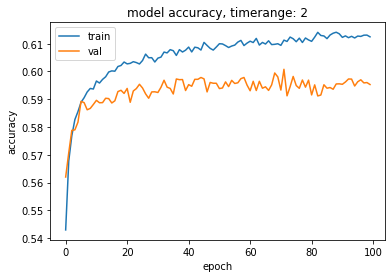

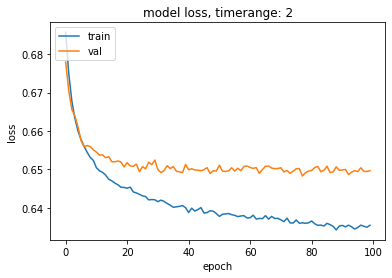

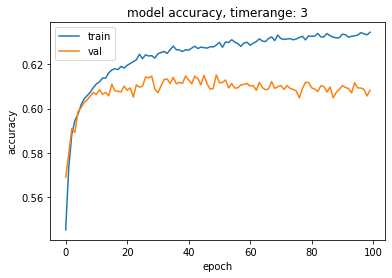

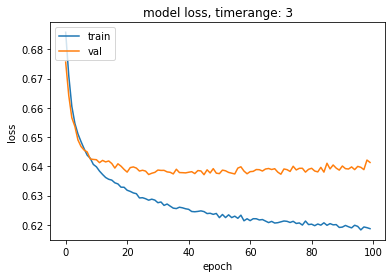

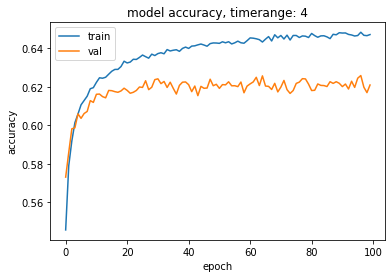

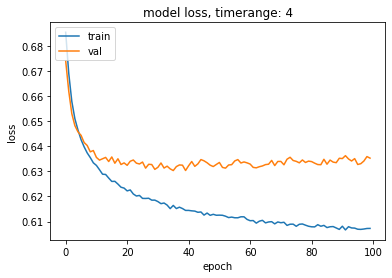

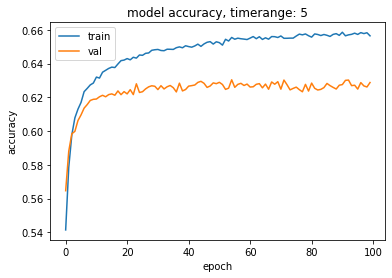

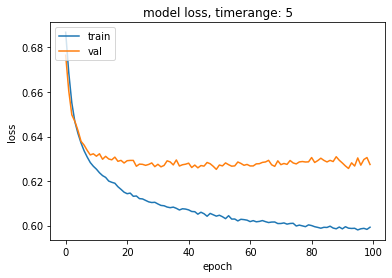

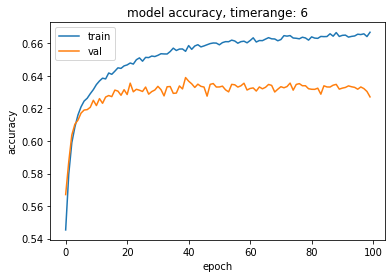

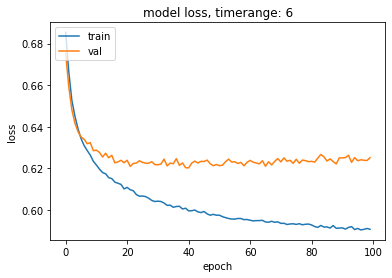

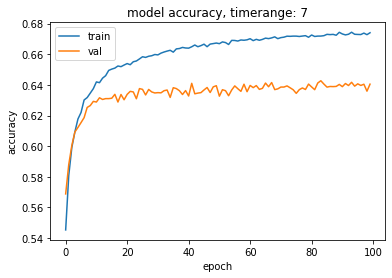

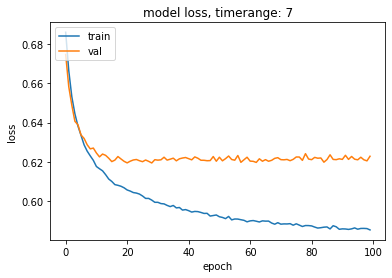

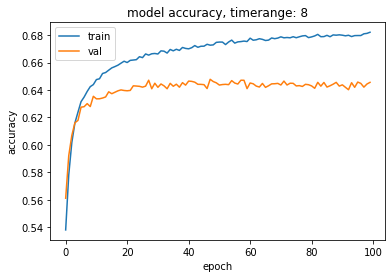

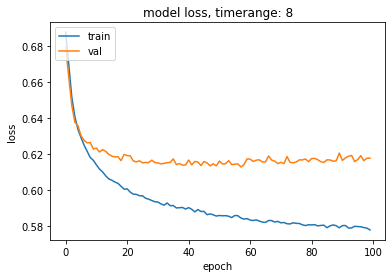

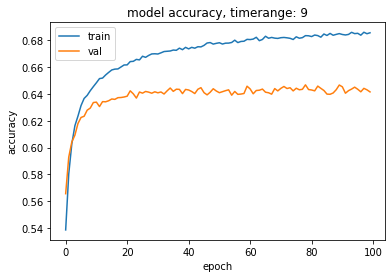

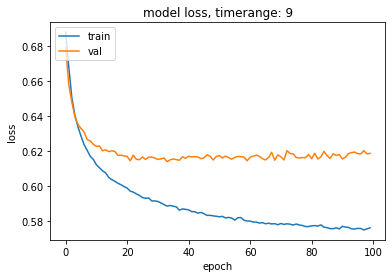

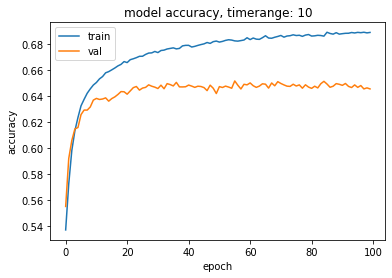

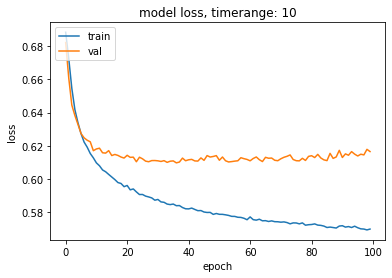

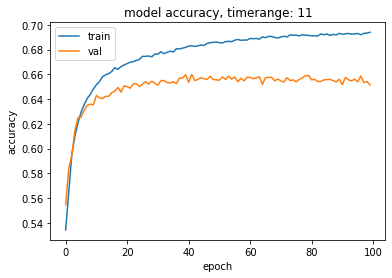

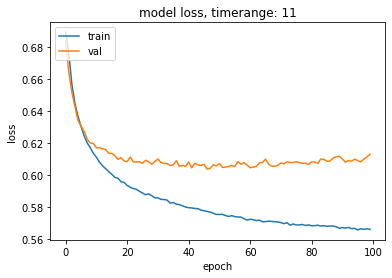

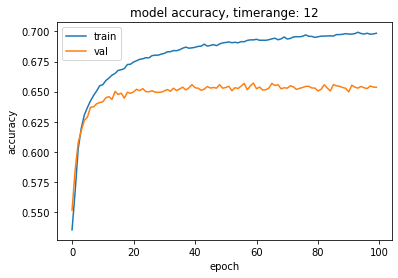

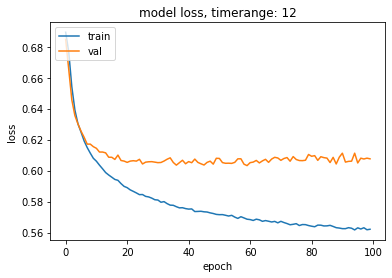

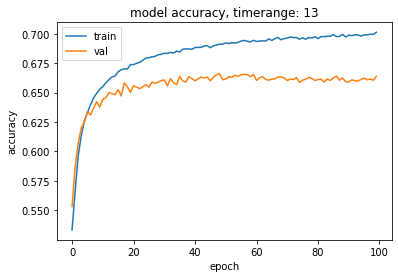

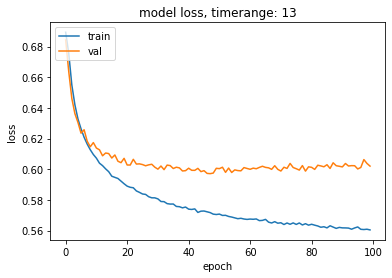

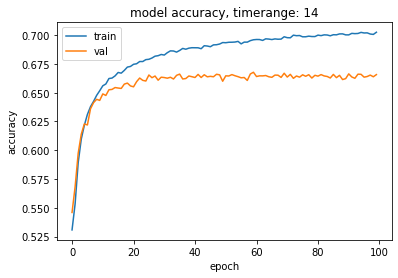

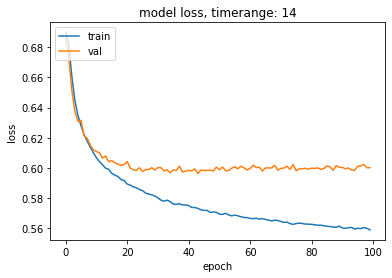

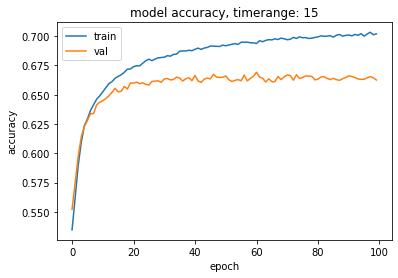

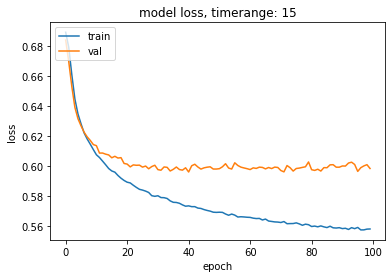

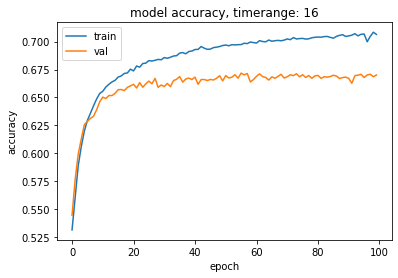

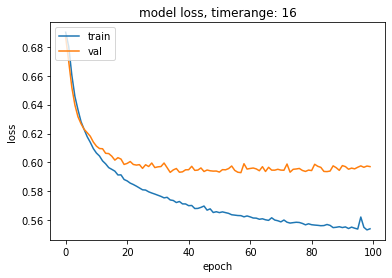

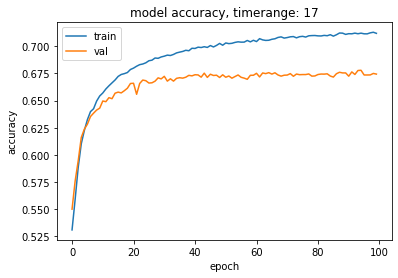

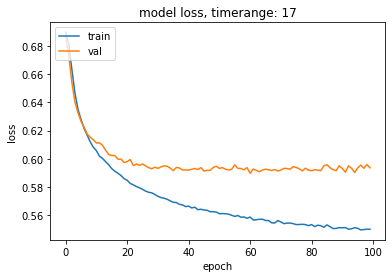

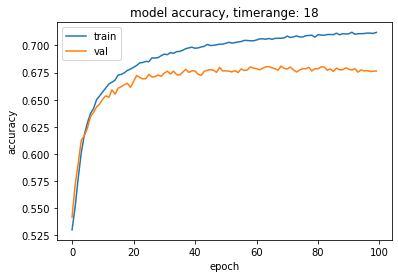

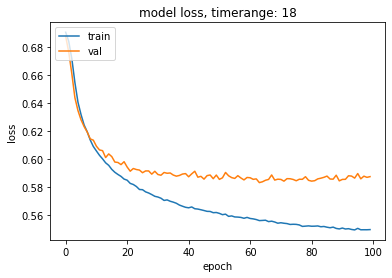

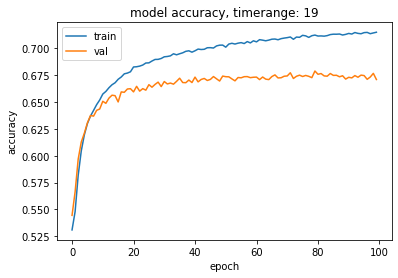

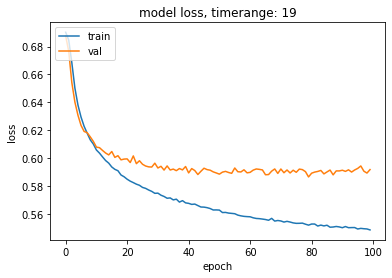

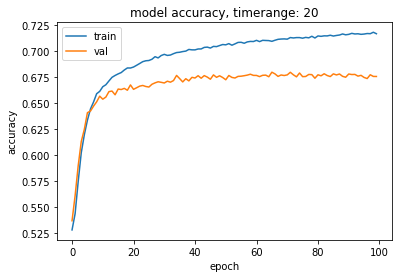

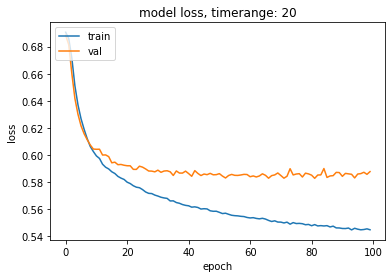

In [14]:
for tr, history in zip(range(2, 21), histories):
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy, timerange: ' + str(tr))
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss, timerange: ' + str(tr))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

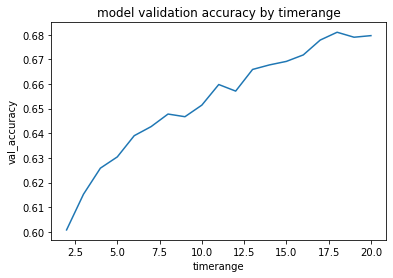

In [17]:
val_history = np.ndarray((21-2))
for i, history in enumerate(histories):
    val_history[i] = np.max(history.history['val_accuracy'])
    
plt.plot(range(2, 21), val_history)
plt.title('model validation accuracy by timerange')
plt.ylabel('val_accuracy')
plt.xlabel('timerange')
plt.show()

In [18]:
TIMERANGE=20
X_test = np.ndarray(shape=(0, TIMERANGE, NUM_FEATURES))
Y_test = np.ndarray(shape=(0))
for stock in all_stocks[TRAIN_SIZE+VALIDATION_SIZE:]:
    X = scaler.transform(stock)
    X = pca.transform(X)
    x_test, y_test = prepare_data(X, stock['close'], timerange=TIMERANGE)
    X_test = np.append(X_test, x_test, axis=0)
    Y_test = np.append(Y_test, y_test, axis=0)

model = Sequential()

model.add(LSTM(units = 30, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=Adam(0.05 / TIMERANGE), metrics=['accuracy'])

model.load_weights(checkpoint_filepath)

print('model evaluation: ', model.evaluate(X_test, Y_test, batch_size=BATCH_SIZE))

186/186 [==============================] - 1s 4ms/step - loss: 0.5783 - accuracy: 0.6874
model evaluation:  [0.5782510638237, 0.6873984932899475]
